In [5]:
import random
import re
from collections import OrderedDict

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score

from Bio import SeqIO
from Bio.Seq import Seq
import mappy as mp
import parasail
from bwapy import BwaAligner

In [ ]:
def extract_gene_name(header):
    parts = header.split("|")
    if len(parts) > 5:
        return parts[5]  # Assuming the gene name is the 6th element in the header
    return None

def filter_reads_by_gene(reads_fn, gene_list, output_fn):
    filtered_reads = []
    
    for record in SeqIO.parse(reads_fn, "fasta"):
        header = record.description
        gene_name = extract_gene_name(header)
        
        if gene_name in gene_list:
            filtered_reads.append(record)
    
    SeqIO.write(filtered_reads, output_fn, "fasta")

df = pd.read_csv('/mnt/869990e7-a61f-469f-99fe-a48d24ac44ca/git/phd-speedrun/genes.csv')
t500 = df['Gene Symbol'].unique()[:500]
filter_reads_by_gene(reads_fn, t500, "t500.fasta")

In [1]:
# base = './data'
# reference_fn = f"{base}/mix.short.fa"

# base = '/mnt/869990e7-a61f-469f-99fe-a48d24ac44ca/git/data/reference/'
# reference_fn = f"{base}/gencode.v45.transcripts.fa"

reference_fn = '/mnt/869990e7-a61f-469f-99fe-a48d24ac44ca/git/phd-speedrun/data/t500_length/t500.fasta'

reads_fn = reference_fn

In [6]:
from Bio import SeqIO
from collections import OrderedDict
import random

# Function to check if the header contains 'protein_coding'
def is_protein_coding(header):
    parts = header.split("|")
    if len(parts) > 7 and parts[7] == "protein_coding":
        return True
    return False

# Function to filter protein_coding sequences
def filter_protein_coding_reads(reads_fn):
    filtered_reads = []
    for record in SeqIO.parse(reads_fn, "fasta"):
        # header = record.description
        # if is_protein_coding(header):
        # if header.split("|")[]
        filtered_reads.append(record)
    return filtered_reads

# Function to add errors to sequences
def add_error(reads, error_rate, truncate=None):
    seq_errors = OrderedDict()
    
    for seq_record in reads:
        sequence = list(seq_record.seq)
        n_errors = int(len(sequence) * error_rate)
        
        for _ in range(n_errors):
            error_type = random.choice(['substitution', 'insertion', 'deletion'])
            idx = random.randint(0, len(sequence) - 1)
            
            if error_type == 'substitution':
                choices = [base for base in ['A', 'T', 'C', 'G'] if base != sequence[idx]]
                sequence[idx] = random.choice(choices)
            
            elif error_type == 'insertion':
                insertion_base = random.choice(['A', 'T', 'C', 'G'])
                sequence.insert(idx, insertion_base)
            
            elif error_type == 'deletion':
                if len(sequence) > 1:  # Ensure there's something to delete
                    sequence.pop(idx)
        
        # Save modified sequence
        if truncate:
            seq_errors[seq_record.id] = ''.join(sequence)[-truncate:] 
        else:
            seq_errors[seq_record.id] = ''.join(sequence)
    
    return seq_errors

# Function to write sequences to FASTA files
def write_fasta_with_errors(seq_errors, output_filename):
    with open(output_filename, 'w') as f:
        for seq_id, sequence in seq_errors.items():
            f.write(f">{seq_id}\n")
            f.write(f"{sequence}\n")

# Main function to apply errors incrementally
def process_reads_with_errors(reads_fn):
    # Filter protein_coding reads
    reads = [seq for seq in list(SeqIO.parse(reads_fn, "fasta"))] 

    Apply error rates and save to separate FASTA files
    for error_rate in [i / 100 for i in range(0, 51, 10)]:
        seq_with_errors = add_error(reads, error_rate)
        output_filename = f"data/t500_error_{int(error_rate * 100)}.fa"
        write_fasta_with_errors(seq_with_errors, output_filename)

    for len in [50, 100, 200, 400, 600, 1000]:
        seq_with_errors = add_error(reads, 0.1, len)
        output_filename = f"data/t500_length/t500_len_{int(len)}.fa"
        write_fasta_with_errors(seq_with_errors, output_filename)

# Example usage
process_reads_with_errors(reads_fn)

In [ ]:
#!/bin/bash

DIRECTORY="./"

for fasta_file in "$DIRECTORY"*.fa
do
  if [[ -f "$fasta_file" ]]; then
    echo "Indexing $fasta_file with bwa index..."
    
    bwa index "$fasta_file"
    
    echo "Finished indexing $fasta_file."
  else
    echo "No .fa files found in the directory."
  fi
done

In [ ]:
#!/bin/bash

errors=(0 10 20 30 40 50)

for err in "${errors[@]}"
do
  echo "Processing with error rate: $err"

  minimap2 -ax map-ont t500_error_"$err".fa t500.fasta | samtools view -h -b -F 4 -F 256 -F 512 -F 2048  > t500_error_"$err".mm2.bam
  
  echo "Finished processing t500_error_$err.bam"
done

for err in "${errors[@]}"
do
  echo "Processing with length: $err"

  minimap2 -ax sr t500_error_"$err".fa t500.fasta | samtools view -h -b -F 4 -F 256 -F 512 -F 2048  > t500_error_"$err".mm2-sr.bam
  
  echo "Finished processing t500_error_$err.bam"
done

for err in "${errors[@]}"
do
  echo "Processing with error rate: $err"

  bwa mem -x ont2d t500_error_"$err".fa t500.fasta | samtools view -h -b -F 4 -F 256 -F 512 -F 2048  > t500_error_"$err".bwa.bam
  
  echo "Finished processing t500_error_$err.bam"
done

for err in "${errors[@]}"
do
  echo "Processing with error rate: $err"

  bwa mem -x ont2d -W 13 -k 6 -T 20 t500_error_"$err".fa t500.fasta | samtools view -h -b -F 4 -F 256 -F 512 -F 2048  > t500_error_"$err".bwa-trna.bam
  
  echo "Finished processing t500_error_$err.bam"
done

In [41]:
import os
import pysam
import pandas as pd

# Function to extract info from the BAM file name
def extract_info_from_filename(filename):
    parts = filename.split('_')
    input_name = parts[0]
    error = parts[2].split('.')[0]
    aligner = parts[2].split('.')[1].replace('.bam', '')
    return input_name, error, aligner

# Function to extract gene name from Genecode format
def get_gene_name(ref_or_query_name):
    return ref_or_query_name.split("|")[5]

# Function to calculate total, correct, and correct gene reads from the BAM content
def get_bam_stats(bam_file):
    total_reads = 0
    correct_reads = 0
    correct_gene_reads = 0

    with pysam.AlignmentFile(bam_file, "rb") as bam:
        for read in bam:
            total_reads += 1
            
            # Check if the read is mapped
            if read.is_unmapped:
                continue
            
            # Extract gene names
            query_gene = get_gene_name(read.query_name)
            reference_gene = get_gene_name(read.reference_name)
            
            # Count correct reads (where query name equals reference name)
            if read.query_name == read.reference_name:
                correct_reads += 1
            
            # Count correct gene reads
            if query_gene == reference_gene:
                correct_gene_reads += 1

    return total_reads, correct_reads, correct_gene_reads

# List all BAM files in a directory
def list_bam_files(directory):
    return [f for f in os.listdir(directory) if f.endswith(".bam")]

# Main function to process BAM files and create DataFrame
def process_bam_files(directory):
    bam_files = list_bam_files(directory)
    
    # Data for the DataFrame
    data = {
        'input': [],
        'error': [],
        'aligner': [],
        'total': [],
        'correct': [],
        'correct_gene': []
    }

    for bam_file in bam_files:
        input_name, error, aligner = extract_info_from_filename(bam_file)
        total_reads, correct_reads, correct_gene_reads = get_bam_stats(os.path.join(directory, bam_file))

        # Append data
        data['input'].append(input_name)
        data['error'].append(error)
        data['aligner'].append(aligner)
        data['total'].append(total_reads)
        data['correct'].append(correct_reads)
        data['correct_gene'].append(correct_gene_reads)

    # Create pandas DataFrame
    df = pd.DataFrame(data)
    return df

# Example usage
directory = "/mnt/869990e7-a61f-469f-99fe-a48d24ac44ca/git/phd-speedrun/data/t500_error"
df = process_bam_files(directory)
df = df.sort_values('error')
df
# Show DataFrame


,input,error,aligner,total,correct,correct_gene
21,t500,0,mm2-sr,6001,5936,6001
19,t500,0,bwa,6002,5934,6002
17,t500,0,bwa-trna,6002,5934,6002
8,t500,0,mm2,6000,5939,6000
0,t500,10,mm2-sr,6000,4359,5997
20,t500,10,mm2,5996,4162,5993
9,t500,10,bwa,6001,5706,6000
11,t500,10,bwa-trna,6002,5719,6002
6,t500,20,mm2-sr,5378,1145,5362
14,t500,20,bwa,6000,5359,5997


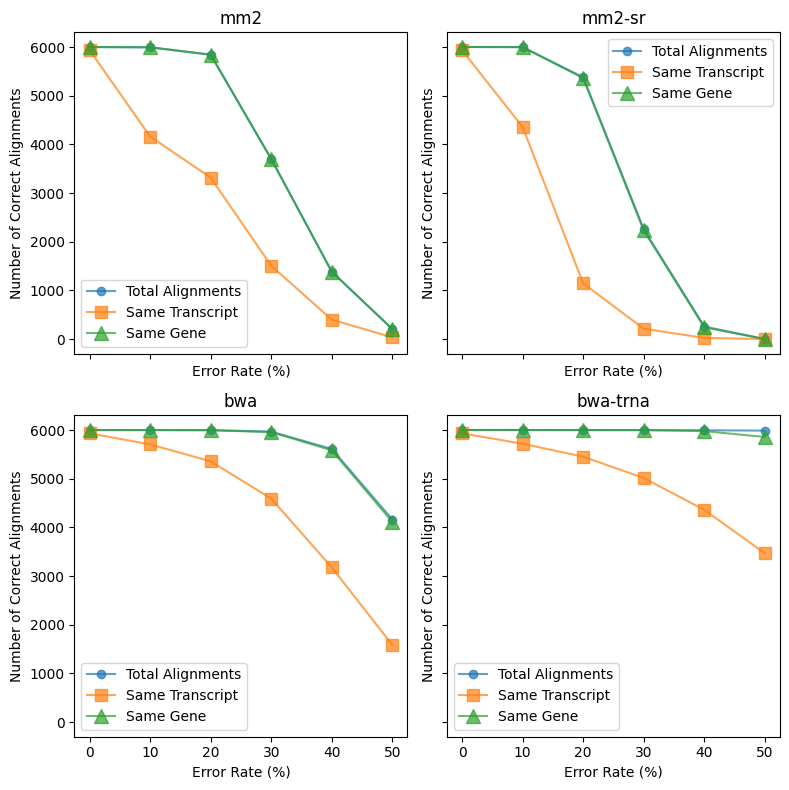

In [42]:
import matplotlib.pyplot as plt

# aligners = df['aligner'].unique()
aligners = ['mm2', 'mm2-sr', 'bwa', 'bwa-trna']
num_aligners = len(aligners)

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(8, 8), sharex=True, sharey=True)  # Adjusted for better layout
axs = axs.flatten()  # Flatten to easily iterate over the axes

# Iterate through aligners and plot data for each
for ax, aligner in zip(axs, aligners):
    # Filter DataFrame for the current aligner
    df_aligner = df[df['aligner'] == aligner]
    
    # Plot number of correct alignments against error rates
    ax.plot(df_aligner['error'], df_aligner['total'], marker='o', label='Total Alignments', alpha=0.7, markersize=6)
    ax.plot(df_aligner['error'], df_aligner['correct'], marker='s', label='Same Transcript', alpha=0.7, markersize=8)  # Square markers
    ax.plot(df_aligner['error'], df_aligner['correct_gene'], marker='^', label='Same Gene', alpha=0.7, markersize=10)  # Triangle markers
    
    # Set axis labels and title
    ax.set_title(aligner)
    ax.set_xlabel('Error Rate (%)')
    ax.set_ylabel('Number of Correct Alignments')
    
    # Add legend
    ax.legend()

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
#!/bin/bash

lengths=(50 100 200 400 600 1000)

for len in "${lengths[@]}"
do
  echo "Processing with length: $len"

  minimap2 -ax map-ont t500_len_"$len".fa t500.fasta | samtools view -h -b -F 4 -F 256 -F 512 -F 2048 > t500_len_"$len".mm2.bam
  
  echo "Finished processing t500_len_$len.bam"
done

for len in "${lengths[@]}"
do
  echo "Processing with length: $len"

  minimap2 -ax sr t500_len_"$len".fa t500.fasta | samtools view -h -b -F 4 -F 256 -F 512 -F 2048 > t500_len_"$len".mm2-sr.bam
  
  echo "Finished processing t500_len_$len.bam"
done

for len in "${lengths[@]}"
do
  echo "Processing with length: $len"

  bwa mem -x ont2d t500_len_"$len".fa t500.fasta | samtools view -h -b -F 4 -F 256 -F 512 -F 2048 > t500_len_"$len".bwa.bam
  
  echo "Finished processing t500_len_$len.bam"
done

for len in "${lengths[@]}"
do
  echo "Processing with length: $len"

  bwa mem -x ont2d -W 13 -k 6 -T 20 t500_len_"$len".fa t500.fasta | samtools view -h -b -F 4 -F 256 -F 512 -F 2048 > t500_len_"$len".bwa-trna.bam
  
  echo "Finished processing t500_len_$len.bam"
done

In [39]:
import os
import pysam
import pandas as pd

# Function to extract info from the BAM file name
def extract_info_from_filename(filename):
    parts = filename.split('_')
    input_name = parts[0]
    length = parts[2].split('.')[0]
    aligner = parts[2].split('.')[1].replace('.bam', '')
    return input_name, length, aligner

# Function to extract gene name from Genecode format
def get_gene_name(ref_or_query_name):
    return ref_or_query_name.split("|")[5]

# Function to calculate total, correct, and correct gene reads from the BAM content
def get_bam_stats(bam_file):
    total_reads = 0
    correct_reads = 0
    correct_gene_reads = 0

    with pysam.AlignmentFile(bam_file, "rb") as bam:
        for read in bam:
            total_reads += 1
            
            # Check if the read is mapped
            if read.is_unmapped:
                continue
            
            # Extract gene names
            query_gene = get_gene_name(read.query_name)
            reference_gene = get_gene_name(read.reference_name)
            
            # Count correct reads (where query name equals reference name)
            if read.query_name == read.reference_name:
                correct_reads += 1
            
            # Count correct gene reads
            if query_gene == reference_gene:
                correct_gene_reads += 1

    return total_reads, correct_reads, correct_gene_reads

# List all BAM files in a directory
def list_bam_files(directory):
    return [f for f in os.listdir(directory) if f.endswith(".bam")]

# Main function to process BAM files and create DataFrame
def process_bam_files(directory):
    bam_files = list_bam_files(directory)
    
    # Data for the DataFrame
    data = {
        'input': [],
        'length': [],
        'aligner': [],
        'total': [],
        'correct': [],
        'correct_gene': []
    }

    for bam_file in bam_files:
        input_name, length, aligner = extract_info_from_filename(bam_file)
        total_reads, correct_reads, correct_gene_reads = get_bam_stats(os.path.join(directory, bam_file))

        # Append data
        data['input'].append(input_name)
        data['length'].append(length)
        data['aligner'].append(aligner)
        data['total'].append(total_reads)
        data['correct'].append(correct_reads)
        data['correct_gene'].append(correct_gene_reads)

    # Create pandas DataFrame
    df = pd.DataFrame(data)
    return df

# Example usage
directory = "/mnt/869990e7-a61f-469f-99fe-a48d24ac44ca/git/phd-speedrun/data/t500_length"
df = process_bam_files(directory)
df['length'] = df['length'].astype(int)
df = df.sort_values('length')
df
# Show DataFrame

,input,length,aligner,total,correct,correct_gene
18,t500,50,mm2,776,86,776
16,t500,50,bwa-trna,6001,1937,5963
13,t500,50,bwa,5565,1522,5509
7,t500,50,mm2-sr,2854,427,2815
0,t500,100,mm2-sr,4856,1068,4824
15,t500,100,bwa-trna,5998,1934,5961
11,t500,100,mm2,4682,1027,4671
2,t500,100,bwa,5566,1519,5480
21,t500,200,mm2-sr,5755,1714,5741
19,t500,200,mm2,5884,2066,5880


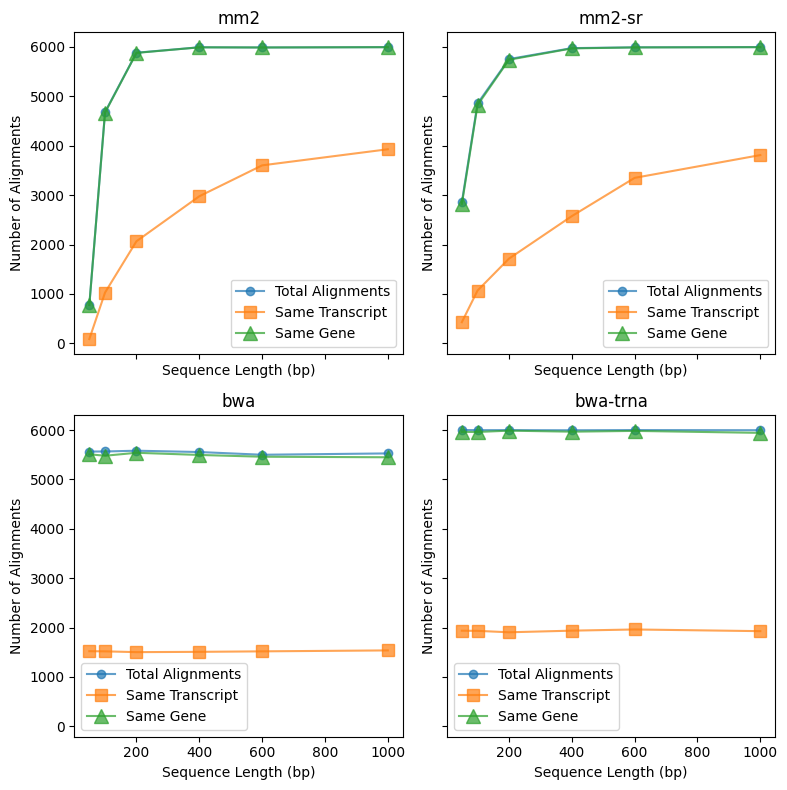

In [40]:
import matplotlib.pyplot as plt

# Sample aligners
aligners = ['mm2', 'mm2-sr', 'bwa', 'bwa-trna']
num_aligners = len(aligners)

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(8, 8), sharex=True, sharey=True)  # Adjusted for better layout
axs = axs.flatten()  # Flatten to easily iterate over the axes

# Iterate through aligners and plot data for each
for ax, aligner in zip(axs, aligners):
    # Filter DataFrame for the current aligner
    df_aligner = df[df['aligner'] == aligner]
    
    # Plot number of correct alignments against length rates with transparency
    # Offsetting values
    offset = 100  # You can adjust this value

    ax.plot(df_aligner['length'], df_aligner['total'], marker='o', label='Total Alignments', alpha=0.7, markersize=6)
    ax.plot(df_aligner['length'], df_aligner['correct'], marker='s', label='Same Transcript', alpha=0.7, markersize=8)  # Square markers
    ax.plot(df_aligner['length'], df_aligner['correct_gene'], marker='^', label='Same Gene', alpha=0.7, markersize=10)  # Triangle markers

    # Set axis labels and title
    ax.set_title(aligner)
    ax.set_xlabel('Sequence Length (bp)')
    ax.set_ylabel('Number of Alignments')
    
    # Add legend
    ax.legend()

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
# NOT USED

In [10]:
def aln_bwa(reads, reference_fn, aligner):
    results = []
    
    for query in reads:
        alignments = aligner.align_seq(str(reads[query]))
        for aln in alignments:
            results.append({
                "query_id": query,
                "ref_id": aln.rname,
                "score": aln.mapq,
                "cigar": aln.cigar,
                # "end_query": aln.q_en,
                # "end_ref": aln.r_en
            })

    return results
    
def aln_mm2(reads, reference_fn, aligner):
    results = []
    for query in reads:
        for aln in aligner.map(str(reads[query])):
            results.append({
                "query_id": query,
                "ref_id": aln.ctg,
                "score": aln.mapq,
                "cigar": aln.cigar_str,
                "end_query": aln.q_en,
                "end_ref": aln.r_en
            })

    return results

def add_error(reads, error_rate):
    seq_errors = OrderedDict()

    for seq_record in reads:
        sequence = list(seq_record.seq)
        n_errors = int(len(sequence) * error_rate)
        
        for _ in range(n_errors):
            error_type = random.choice(['substitution', 'insertion', 'deletion'])
            idx = random.randint(0, len(sequence) - 1)
            
            if error_type == 'substitution':
                choices = [base for base in ['A', 'T', 'C', 'G'] if base != sequence[idx]]
                sequence[idx] = random.choice(choices)
            
            elif error_type == 'insertion':
                insertion_base = random.choice(['A', 'T', 'C', 'G'])
                sequence.insert(idx, insertion_base)
            
            elif error_type == 'deletion':
                if len(sequence) > 1:  # ensure there is something to delete
                    sequence.pop(idx)
            
        seq_errors[seq_record.id] = ''.join(sequence)
            
    return seq_errors

def trunc(reads, seq_len):
    trunc_reads = []
    for seq_record in reads:
        truncated_seq = seq_record.seq[-seq_len:]  # Get the last `seq_len` bases from the sequence.
        seq_record.seq = truncated_seq  # Update the sequence in the SeqRecord object.
        trunc_reads.append(seq_record)  # Append the truncated SeqRecord.
    return trunc_reads

def calculate_metrics(true_labels, predicted_labels):
    if not true_labels or not predicted_labels:
        return np.nan, np.nan, np.nan, np.nan, np.nan, np.nan
    
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels, average='micro')
    recall = recall_score(true_labels, predicted_labels, average='micro')
    f1 = f1_score(true_labels, predicted_labels, average='micro')
    cm = confusion_matrix(true_labels, predicted_labels, labels=np.unique(true_labels + predicted_labels))
    
    # Calculate FPR
    FP = cm.sum(axis=0) - np.diag(cm)
    TN = cm.sum() - (FP + cm.sum(axis=1) - np.diag(cm))
    FPR = FP / (FP + TN)
    
    # Since FPR is a per-class measure, we need to average it across classes
    FPR_average = np.sum(FPR)
    
    return accuracy, precision, recall, f1, cm, FPR_average

def extract_labels(alignment_results):
    true_labels = [alignment['query_id'] for alignment in alignment_results]
    predicted_labels = [alignment['ref_id'] for alignment in alignment_results]
    return true_labels, predicted_labels

In [15]:
reference = [seq for seq in list(SeqIO.parse(reference_fn, "fasta"))]
reads = [seq for seq in list(SeqIO.parse(reads_fn, "fasta"))]

alr_mm2 = mp.Aligner(reference_fn, None)
alr_mm2_sr = mp.Aligner(reference_fn, 'sr')
alr_bwa = BwaAligner(reference_fn, '')
alr_bwa_ont = BwaAligner(reference_fn, '-x ont2d')
# alr_bwa_trna = BwaAligner(reference_fn, '-x ont2d -W 13 -k 6 -T 20')

In [16]:
results = []

for error_rate in [i / 100 for i in range(0, 11, 10)]:
    # for label_mat, matrix in matrices:
    for iteration in range(1):
        print(f'error_rate: {error_rate}')
        print(f'iteration: {iteration}')

        random.seed(iteration)
        reads_with_errors = add_error(reads, error_rate)
        print('adding error complete')
    
        # minimap2 alignment
        mm2_result = aln_mm2(reads_with_errors, reference_fn, alr_mm2)
        results.append({"aligner": "mm2", "error_added": error_rate * 100, "alignment_result": mm2_result})

        mm2_result = aln_mm2(reads_with_errors, reference_fn, alr_mm2_sr)
        results.append({"aligner": "mm2 sr", "error_added": error_rate * 100, "alignment_result": mm2_result})

        print('mappy complete')

        # bwa alignment
        bwa_result = aln_bwa(reads_with_errors, reference_fn, alr_bwa)
        results.append({"aligner": "bwa", "error_added": error_rate * 100, "alignment_result": bwa_result})

        bwa_result = aln_bwa(reads_with_errors, reference_fn, alr_bwa_ont)
        results.append({"aligner": "bwa -x ont2d", "error_added": error_rate * 100, "alignment_result": bwa_result})

        print('bwapy complete')

        # bwa_result = aln_bwa(reads_with_errors, reference_fn, alr_bwa_trna)
        # results.append({"aligner": "bwa -x ont2d b", "error_added": error_rate * 100, "alignment_result": bwa_result})

df = pd.DataFrame(results)

metrics = df['alignment_result'].apply(lambda x: calculate_metrics(*extract_labels(x)))

# Extract individual metrics and add them to the DataFrame
df['accuracy'] = metrics.apply(lambda x: x[0])
df['precision'] = metrics.apply(lambda x: x[1])
df['recall'] = metrics.apply(lambda x: x[2])
df['f1_score'] = metrics.apply(lambda x: x[3])
df['FPR'] = metrics.apply(lambda x: x[5])

error_rate: 0.0
iteration: 0
adding error complete
mappy complete
bwapy complete
error_rate: 0.1
iteration: 0
adding error complete
mappy complete
bwapy complete


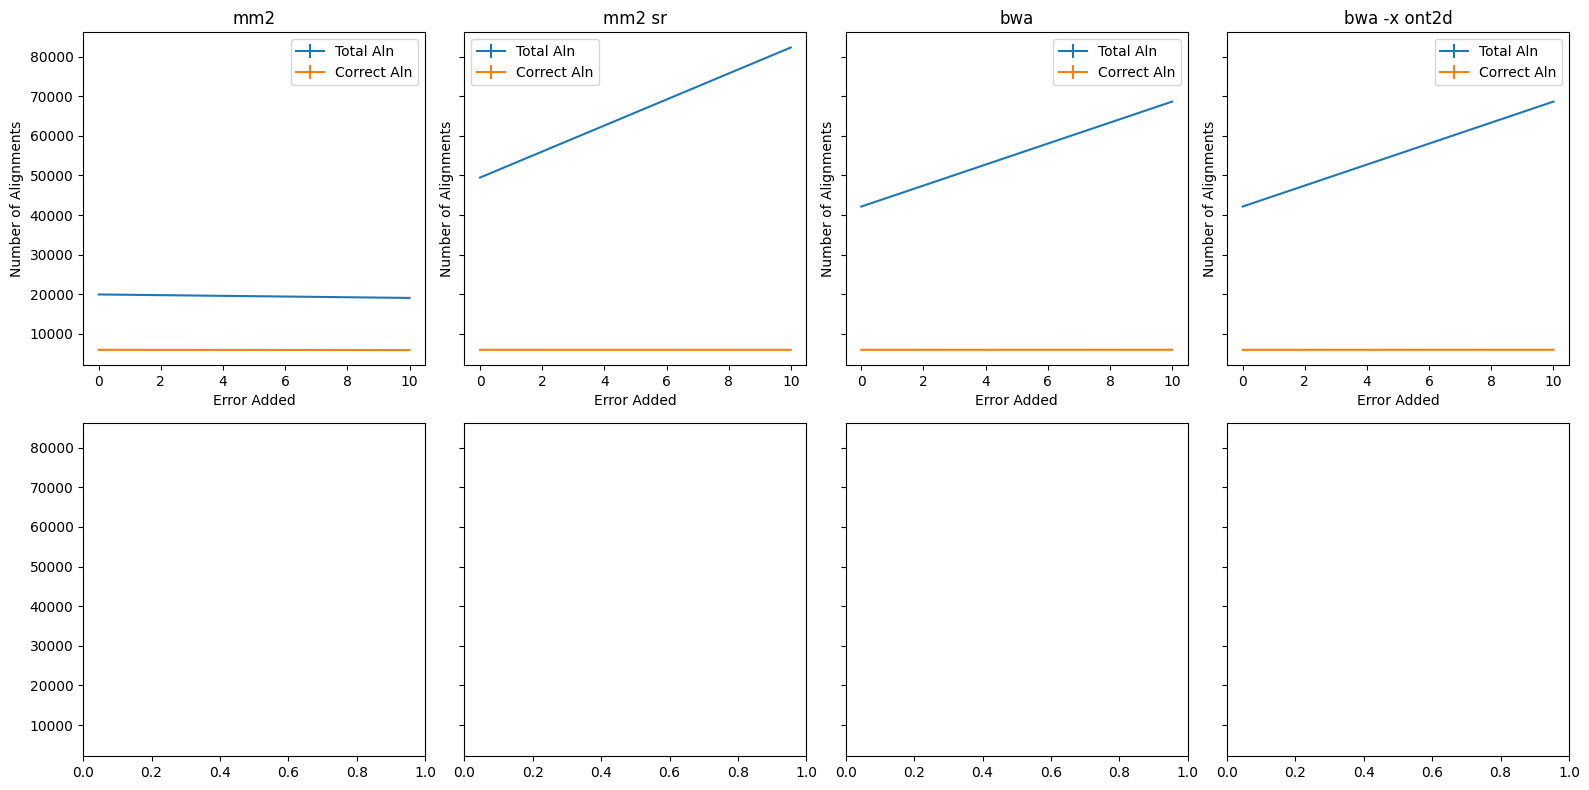

In [17]:

aligners = df['aligner'].unique()
num_aligners = len(aligners)

# Assuming 'df' is your DataFrame and 'aligners' is the list of aligners
fig, axs = plt.subplots(2, 4, figsize=(16, 8), sharex=False, sharey=True)
axs = axs.flatten()  # Flatten to easily iterate over

for ax, aligner in zip(axs, aligners):
    subset = df[df['aligner'] == aligner].copy()
    subset['alignment_total'] = subset['alignment_result'].apply(lambda arr: len(arr))
    subset['alignment_correct'] = subset['alignment_result'].apply(lambda arr: sum(1 for x in arr if x['query_id'] == x['ref_id']))

    # Group by 'error_added' and compute mean and std
    stats = subset.groupby('error_added').agg({
        'alignment_total': ['mean', 'std'],
        'alignment_correct': ['mean', 'std']
    }).reset_index()
    
    # Extract values for plotting
    error_added = stats['error_added']
    total_mean = stats['alignment_total']['mean']
    total_std = stats['alignment_total']['std']
    correct_mean = stats['alignment_correct']['mean']
    correct_std = stats['alignment_correct']['std']

    # Plot average lines with error bars
    ax.errorbar(error_added, total_mean, yerr=total_std, label='Total Aln')
    ax.errorbar(error_added, correct_mean, yerr=correct_std, label='Correct Aln')
    
    ax.set_title(aligner)
    ax.set_xlabel('Error Added')
    ax.set_ylabel('Number of Alignments')
    ax.legend()
    # ax.set_ylim(top=70)
    
plt.tight_layout()